# plot_kw-spectra-ratio_WKBamp

plot ratio of WKB amp in $k-\omega$ space

adapted from *plot_kw-spectra_ratio.ipynb* and *plot_kw-spectra_WKBamp.ipynb*

Ratio is computed only where KE density <ins>at depth</ins> is high enough.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth']= 2
import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import AxesGrid
import scipy.interpolate as itp
import sys
if "/home/lahaye/Coding/python_science" not in sys.path:
    sys.path.append("/home/lahaye/Coding/python_science")
import colormaps as cm
import ML_ModeSolve as mls

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"


In [2]:
# useful functions
def IWdisprel(kk, nmod=1, N=2.5e-3, H=3.4, f=8.85e-5):
    """ relation dispersion for internal waves, k and H in km, N and f in s-1
    returns omega in cpd """
    return np.sqrt((N*kk/nmod/np.pi*H)**2 + f**2)*3600*24/2/np.pi

def bleacher(color, alpha):
    return alpha[:,None] * color + (1 - alpha[:,None])

def dasaro(k, dml, Nsqr, gred): # cf D'Asaro 1978, hydro
    return 1./(k**2*Nsqr*dml**2 + (1-k**2*gred*dml)**2)


In [3]:
simuls = ["luckyt"]#, "luckyt"] # ["luckyt"] #
seasons = ['summer','winter']#["winter"]
idup = -0. # integer -> index, float -> depth
iddn = -500. # NB integer will probably be wrong because depths is not ordered in netCDF files

path_data = RUCHBA+"data_from_Irene/kw_spectra/"
#path_spec = path_data+"{0}_kw-spec_{1}_{2}.nc".format("{0}",what,"{1}")

# plotting parameters
dosavefig = False
dirpic = "pictures/paper_figs/"
cols = {"das":"tab:red", "wkb":"tab:olive", "num":"tab:blue", 
        "raw":"black"}

# initialise path
ncfil = {simul:{} for simul in simuls}
for simul,values in ncfil.items():
    for sea in ["summer","winter"]:
        values[sea] = "{0}_kw-spec_{1}_{2}.nc".format(simul,"{}",sea[:3])
if "luckym2" in ncfil and 'summer' in ncfil['luckym2']:
    ncfil['luckym2']['summer'] = ncfil['luckym2']['summer'].replace('luckym2','luckym2s')

# various parameters
fcor, fcin, fcax = 8.85e-5, 8.62e-5, 9.08e-5 # coriolis at (center, 1/4, 3/4) [rad/s]
Hmoy = 2.5   # km
nmods = [1, 2, 3, 10, 20]  # modes dispersion curve to show
dx, Lx = 0.750, 1500 # horizontal resolution model
fmin = 1./7 # min frequency to show, in cpd

#lscal = [10, 100]    # typical lengthscales (km) to show
fscal = [11.96, 12.42, 12.42/2., (2*np.pi/fcor)/3600] # typical time scale (in hour)
flabs = [r'$S_2$', r'$M_2$', r'$2 M_2$', r"$f$"]

# get depths (not generic, just for HKE netCDF file):
nc = Dataset(path_data+ncfil[simuls[0]][seasons[0]].format("HKE"), "r")
depths, izs = np.zeros(2), np.zeros(2)
for ii,iz in enumerate([idup,iddn]):
    if isinstance(iz,int):
        depths[ii] = nc.variables["depths"][iz]
        izs[ii] = iz
    else:
        izs[ii] = abs(nc.variables["depths"][:]-iz).argmin()
        depths[ii] = nc.variables["depths"][izs[ii]]
izup, izdn = izs
print("depths",depths,"indices",izs,"asked",idup,iddn)
nc.close()

# compute mean BVF
Nmoy = {sea:np.nan for sea in seasons}
for sea,pap in zip(["summer","winter"],["luckym2s","luckym2"]):
    path_strat = KRYPTON+"DIAG/{}_bvf_moy.nc".format(pap)
    nc = Dataset(path_strat, "r")
    zinterp = nc.variables['z'][:]
    bvfm = nc.variables['bvf'][:]
    nc.close()
    bvfm = itp.interp1d(zinterp, bvfm)(depths)
    if ((bvfm)<0).any():
        print(sea,"found negative mean BVF at depth", depth[bvfm<0])
        bvfm[bvfm<0] = np.nan
    Nmoy[sea] = np.sqrt(bvfm)
    print(sea+' Nmoy at is {1:.2e} at {0}m'.format(int(depths[0]),Nmoy[sea][0]), end=", ")
    if len(depths)>1: 
        for ii in range(1,len(depths)):
            print("{0:.2e} at {1}m".format(Nmoy[sea][ii],int(depths[ii])), end=", ")
    print("")
del zinterp, bvfm

depths [   0. -500.] indices [ 3.  0.] asked -0.0 -500.0
summer Nmoy at is 6.67e-03 at 0m, 3.85e-03 at -500m, 
winter Nmoy at is 2.03e-03 at 0m, 3.85e-03 at -500m, 


In [4]:
# Load data and compute ratio
specrat = {simul:{} for simul in simuls}
specmax = {simul:{} for simul in simuls}
freq = {simul:{} for simul in simuls}
kk = {simul:{} for simul in simuls}

fmax = np.inf

for isim,simul in enumerate(simuls):
    for isea,sea in enumerate(seasons):
        nc = Dataset(path_data+ncfil[simul][sea].format("HKE"), "r")
        kk[simul][sea] = nc.variables['k'][:] 
        ff = nc.variables['freq'][:] # cyc/h
        print(simul,sea,nc.variables['k'].units,nc.variables['freq'].units)
        freq[simul][sea] = ff
        iz = abs(nc.variables['depths'][:]-depths[0]).argmin()
        if nc.variables['depths'][iz] != depths[0]: print("warning, depths:",nc.variables['depths'][iz],depths[0])
        hkup = nc.variables["spectrum"][iz,:,:]
        iz = abs(nc.variables['depths'][:]-depths[1]).argmin()
        if nc.variables['depths'][iz] != depths[1]: print("warning, depths:",nc.variables['depths'][iz],depths[1])
        hkdn = nc.variables["spectrum"][iz,:,:]
        nc.close()
        
        nc = Dataset(path_data+ncfil[simul][sea].format("VKE"), "r")
        iz = abs(nc.variables['depths'][:]-depths[0]).argmin()
        if nc.variables['depths'][iz] != depths[0]: print("warning, depths:",nc.variables['depths'][iz],depths[0])
        vkup = nc.variables["spectrum"][iz,:,:]
        iz = abs(nc.variables['depths'][:]-depths[1]).argmin()
        if nc.variables['depths'][iz] != depths[1]: print("warning, depths:",nc.variables['depths'][iz],depths[1])
        vkdn = nc.variables["spectrum"][iz,:,:]
        nc.close()
        
        fmax = min(fmax,ff.max())
        om = 2*np.pi*ff[:,None]/3600 # rad/s
        if not np.isnan(Nmoy[sea][0]):
            amup = hkup + vkup * Nmoy[sea][0]**2*(1+fcor**2/om**2)/(om**2-fcor**2)/2
        else:
            amup = hkup
        amdn = hkdn + vkdn * Nmoy[sea][1]**2*(1+fcor**2/om**2)/(om**2-fcor**2)/2
        amdn[om.squeeze()<fcor,:] = 0
        specrat[simul][sea] = np.where(amdn==0, hkup/hkdn, amup/amdn)
        specmax[simul][sea] = 0.5*np.where(amdn==0, hkdn, amdn) #np.where(spup>spdn, spup, spdn)

#del hkup, hkdn, vkdn, amp


luckyt summer rad/km h^{-1}
luckyt winter rad/km h^{-1}


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


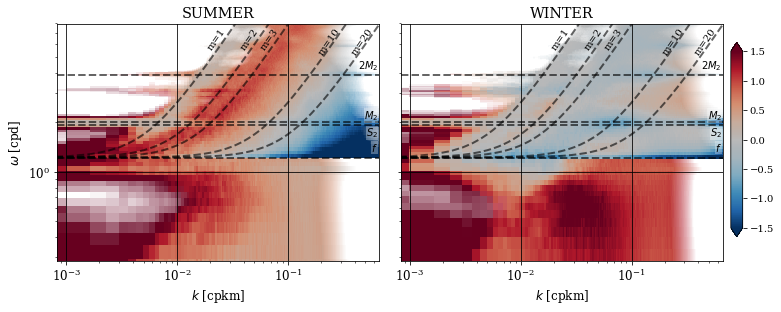

In [7]:
# plot
cmap = cm.dark_redblue(rev=True,coef=0.25)
gcol = "k"
vmin, vmax = -1.5, 1.5
dotrunc = True # change color intensity according to value of spetral density (do not show low energy regions)
alrange = -3, -2 # range over which intensity varies linearly (log10(data))
shad = "flat" if dotrunc else "gouraud"
alpha = 0.6 # alpha for additional lines

fig, axs = plt.subplots(len(simuls), len(seasons), sharex=True, sharey=True \
                        , figsize=(5*len(seasons)+1,4.5*len(simuls)))
if len(simuls)==1 or len(seasons)==1: axs = np.array([axs])
    
pcs = []
for isim,simul in enumerate(simuls):
    for isea,sea in enumerate(seasons):
        ax = axs.ravel()[isim*len(seasons)+isea]
        data = specrat[simul][sea][1:,1:]
        kpl = kk[simul][sea][:]
        fpl = freq[simul][sea][:] * 24
        if shad == "flat":
            kpl = np.r_[0.5*(kpl[1:]+kpl[:-1]), 1.5*kpl[-1]-0.5*kpl[-2]]
            fpl = np.r_[0.5*(fpl[1:]+fpl[:-1]), 1.5*fpl[-1]-0.5*fpl[-2]]
        else:
            kpl, fpl = kpl[1:], fpl[1:]
        hpc = ax.pcolormesh(kpl/2./np.pi, fpl, np.log10(data), vmin=vmin, vmax=vmax, cmap=cmap \
                            , shading=shad, edgecolor=None)
        pcs.append(hpc)
        del hpc
        ax.set_title(sea.upper())
        ## add dispersion curves and stuff
        for nmod in nmods:
            ax.plot(kpl/2./np.pi, IWdisprel(kpl, nmod=nmod), '--k', alpha=alpha)
            ix = abs(IWdisprel(kpl, nmod)-fmax*24).argmin()
            ax.text(kpl[ix]/3.7/np.pi, fmax*21, r"m={}".format(nmod), rotation=55, fontsize=10)# \
                   # , bbox=dict(facecolor="w", edgecolor="none", alpha=.3, pad=.1))
        for ll,la in zip(fscal,flabs):
            ax.axhline(24./ll, linestyle='--', color='k', alpha=alpha)
            vshift = 0.82 if la==r'$S_2$' else 1.09
            ax.text(.49/dx, vshift*24./ll, la, fontsize=10, ha="right" \
                    , bbox=dict(facecolor="w", edgecolor="none", alpha=.3, pad=.2))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1.25/Lx, .5/dx])
#ax.set_ylim([fcor/2/np.pi*3600*24,fmax*24])
ax.set_ylim([2*fmin,fmax*24])
for ax in axs.ravel():
    ax.grid(color=gcol)    
for ax in axs[-1]:
    ax.set_xlabel(r'$k$ [cpkm]')
for iax in range(len(simuls)):
    axs.ravel()[iax*len(seasons)].set_ylabel(r'$\omega$ [cpd]')

fig.tight_layout()

#ftit = r'WKB amp -- ratio {0}/{1} m'.format(int(depths[0]),int(depths[1]))
#fig.suptitle(ftit, y=1.00)

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.25, 0.015, 0.6])
ac = plt.colorbar(pcs[0], cax=cbar_ax, extend="both")
ac.ax.tick_params(labelsize=10)
#ac.set_label(what+' (log)')

if dotrunc:     # apply shading
    for isim,simul in enumerate(simuls):
        for isea,sea in enumerate(seasons):
            alphas = (np.clip(np.log10(specmax[simul][sea][1:,1:]), alrange[0], alrange[1])-alrange[0])/(alrange[1]-alrange[0])
            fig.canvas.draw()
            colors = pcs[isim*len(seasons)+isea].get_facecolor()[:,:3]
            pcs[isim*len(seasons)+isea].set_facecolor(bleacher(colors, alphas.ravel()))
            fig.canvas.draw()
        
if dosavefig:
    if len(simuls)==1:
        picnam = dirpic+"{0}".format(simul)
    else:
        picnam = dirpic+"Simuls"
    picnam += "_kw-spec_WKBamp-ratio_z{0}o{1}.png".format(int(abs(depths[0])),int(abs(depths[1])))
    plt.savefig(picnam, magnification="auto", dpi=250, bbox_inches="tight")


## Trying to compare against D'Asaro 1978

In [8]:
# compute theoretical solutions: "summer", "winter"
path_strat = {sea:RUCHBA+"{0}_tseries_lf/{0}_subsamp_strat_{1}.nc".format("luckyt",sea[:3]) for sea in seasons}

Hbt = 3.4e3
dmlnu = {"summer":25., "winter":0} # numerical resolution
dmlth = {"summer":25., "winter":150.} # theoretical (e.g. d'asaro)
gr_nu = {"summer":0, "winter":0} # {"summer":1.2e-2, "winter":0}
gr_th = {"summer":1.2e-2, "winter":0}
dmlkb, gr_kb = dmlth, gr_nu

zref = -500
zpyc = -200
Nsqml = {"summer":0, "winter":0} # {"summer":0., "winter":0.}

Nmoy = {"summer":np.sqrt(6.8e-6), "winter":np.sqrt(5.2e-6)}

nmod = 40

# solving full problem
rat_evp = {sea:mls.get_ModAmpRat(path_strat[sea], Hbt, dmlnu[sea], gr_nu[sea], zref, zpyc, Nsqml[sea]) for sea in seasons}
rat_evp = {sea:(rat_evp[sea][0][:nmod].real, rat_evp[sea][1][:nmod]) for sea in seasons}
# WKB sol
rien = {sea:mls.get_ModAmpRat(path_strat[sea], Hbt, dmlkb[sea], gr_kb[sea], zref, zpyc, Nsqml[sea]) for sea in seasons}
rat_wkb = {sea:mls.get_WKBampRat(path_strat[sea], rien[sea][0][:nmod].real, dmlkb[sea], Hbt, zref, zpyc, Nsqml[sea], gr_kb[sea]) for sea in seasons}

no Mixed Layer


/home/lahaye/working_on/SeaSurf_IntWaves/ML_ModeSolve.py:110: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(wo[:Nin,:]**2*np.sqrt(Nsqin)[:Nin,None] \
/home/lahaye/working_on/SeaSurf_IntWaves/ML_ModeSolve.py:111: RuntimeWarning: invalid value encountered in sqrt
  + (do[:Nin,:]**2/np.sqrt(Nsqin)[:Nin,None])).mean(axis=0)


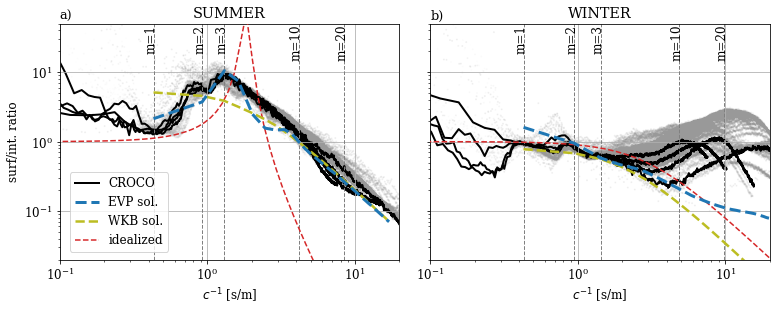

In [21]:
# take "lines" of amp previously computed (TODO try with ratio at several frequencies from locally averaged PSD)
# Not sure the figure would work for 1 simul, 1 season

docloud = True # plot all data with transparency

fzos = [1/12.42, 2/12.42, 3/12.42, 4/12.42] # take several frequencies

fig, axs = plt.subplots(len(simuls), len(seasons), sharex=True, sharey=True \
                        , figsize=(5*len(seasons)+1,4.5*len(simuls)))
if len(simuls)==1 or len(seasons)==1: axs = np.array([axs])

kpt = np.logspace(-2,2,100)

for isim,sim in enumerate(simuls):
    for isea,sea in enumerate(seasons):
        ff = freq[sim][sea]
        kpl = kk[sim][sea][1:]
        amp = specrat[sim][sea][:,1:]
        ax = axs[isim][isea]
        if docloud:
            indf, = np.where(freq[sim][sea]*2*np.pi/3600 > fcor)
            om = freq[sim][sea][indf]*2*np.pi/3600
            kred = kpl[None,:]/np.sqrt(om[:,None]**2-fcor**2)/1e3
            data = amp[indf,:]
            if dotrunc:
                alphas = (np.clip(np.log10(specmax[sim][sea][indf,1:]), alrange[0] \
                                  , alrange[1])-alrange[0])/(alrange[1]-alrange[0])
                colz = np.c_[np.tile(np.ones((alphas.size,1))*.6,(1,3)), alphas.ravel()*.1]
            else:
                colz = [.6]*3
            ax.scatter(kred.ravel(), data.ravel(), s=1, c=colz, zorder=0)
        for f0 in fzos:
            ii = abs(ff-f0).argmin()
            om = 2*np.pi*ff[ii]/3600
            ax.loglog(kpl/np.sqrt(om**2-fcor**2)/1e3, amp[ii,:], "k", label="CROCO", zorder=1)
        ax.loglog(rat_evp[sea][0], rat_evp[sea][1], '--', color=cols["num"], label="EVP sol.", lw=3, zorder=5)
        ax.loglog(rat_evp[sea][0], rat_wkb[sea], '--', color=cols["wkb"], label="WKB sol.", lw=2.5, zorder=4)
        ax.loglog(kpt, mls.fasa(kpt, dmlth[sea], Nmoy[sea]**2, gr_th[sea]), "--" \
                  , color=cols["das"], label="idealized", lw=1.5, zorder=3)
        for nm in nmods:
            keq = rat_evp[sea][0][nm-1]#nm*np.pi/Hbt/Nmoy[sea]
            ax.axvline(keq, color="grey", linestyle="--", linewidth=1)
            ax.text(.87*keq, 35, "m={}".format(nm), rotation=90)
        
for ia,ax in enumerate(axs.ravel()):
    ax.grid(True)
    ax.set_ylim([2e-2, 5e1])
    ax.set_xlim([1e-1, 2e1])
    ax.text(.0, 1.02, "abcd"[ia]+")", transform=ax.transAxes, fontsize=13)
for ia,ax in enumerate(axs[0,:]):
    ax.set_title(seasons[ia].upper())
for ax in axs[-1,:]:
    ax.set_xlabel(r'$c^{-1}$ [s/m]')
for ax in axs[:,0]:
    ax.set_ylabel(r'surf/int. ratio')
    
fig.tight_layout()

leg = fig.legend(bbox_to_anchor=[.22,.45])

if dosavefig:
    fig.savefig(dirpic+"CompAll_kred_WKBamp-ratio_z{0}o{1}.png".format(int(abs(depths[0])),int(abs(depths[1]))) \
                        , magnification="auto", bbox_inches="tight", dpi=200)

In [15]:
fig.savefig(dirpic+"CompAll_kred_WKBamp-ratio_z{0}o{1}.png".format(int(abs(depths[0])),int(abs(depths[1]))) \
                        , magnification="auto", bbox_inches="tight", dpi=200)